<a href="https://colab.research.google.com/github/EudoraHan/User-Churn-Prediction/blob/develop/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Churn Prediction

Yun Han 

7/24/2019

## Contents

# Part 0: Upload dataset from local

In [0]:
from google.colab import files
uploaded = files.upload()

Saving churn.all.csv to churn.all.csv


In [0]:
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['churn.all.csv']))
df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


# Part 1 : Data Exploration

## Part 1.1 : Dataset description

In [0]:
print("Number of rows:" + str(df.shape[0]))
print("Number of columns:" + str(df.shape[1]))

Number of rows:5000
Number of columns:21


## Part 1.2 : Data cleaning

The column "voice_mail_plan", "intl_plan" and "churned" have extra white space in every observation. We need to remove these whitespace.

In [0]:
# check categorical feature
df['voice_mail_plan'][0]

' yes'

In [0]:
# remove the heading and trailing whitespaces
# strip() in-built function of Python is used to remove all the leading and trailing spaces from a string.
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x: x.strip())
df['intl_plan'] = df['intl_plan'].map(lambda x: x.strip())
df['churned'] = df['churned'].map(lambda x: x.strip()) 

In [0]:
# check categorical feature after manipulation
df['voice_mail_plan'][0]

'yes'

## Part 1.3 : Understand the features

In [0]:
# check the missing value
df.isnull().sum()

state                            0
account_length                   0
area_code                        0
phone_number                     0
intl_plan                        0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churned                          0
dtype: int64

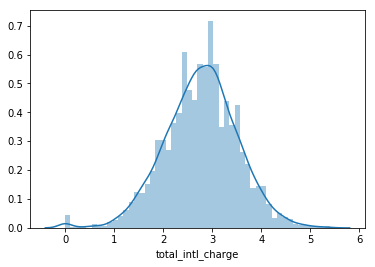

In [0]:
# check the feature distribution 
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df['total_intl_charge'])

In [0]:
# correlation between all the features
corr = df[["account_length", "number_vmail_messages", "total_day_minutes", 
           "total_day_calls", "total_day_charge", "total_eve_minutes", 
           "total_eve_calls", "total_eve_charge", "total_night_minutes", 
           "total_night_calls", "total_night_charge", "total_intl_minutes", 
           "total_intl_calls", "total_intl_charge"]].corr()

# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.000656,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.005535,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,0.011783,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.002802,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,0.011785,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,-0.016642,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,0.001799,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,-0.016652,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,0.999999,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.026949,0.000391,-0.000156,0.000368


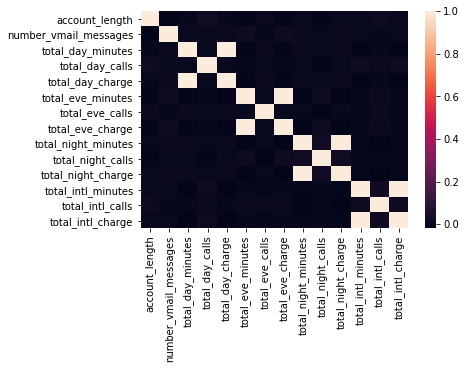

In [0]:
# Show the heatmap of correlations
sns.heatmap(corr)

From the correlation matrix we can see, the correlation between "total_charge" and "total_minutes" is 1. Hence, we can delete one of the them in each pair.


In [0]:
# Delete the high correlation variable: shot_distance, game_event_id,game_id
churn = df.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'], axis = 1)


# Part 2 : Feature Preprocessing

In [0]:
# Drop some useless columns
churn = churn.drop(['state', 'area_code', 'phone_number'], axis = 1)

In [0]:
# Label Encoding for String
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
churn.intl_plan = labelencoder.fit_transform(churn.intl_plan)
churn.voice_mail_plan = labelencoder.fit_transform(churn.voice_mail_plan)
churn.churned = labelencoder.fit_transform(churn.churned)

In [0]:
# Get X and y
X = churn.iloc[:, :-1].values
y = churn.iloc[:, -1].values

In [0]:
# Check the proportion of y = 1
print(y.sum()/y.shape)

[0.1414]


# Part 3 : Model Training -- Random Forest

## Part 3.1 : Split dataset

In [0]:
# Split data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('Training data has %d observation with %d features' % X_train.shape)
print('Test data has %d observation with %d features' % X_test.shape)

Training data has 4000 observation with 13 features
Test data has 1000 observation with 13 features


In [0]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(4000, 13)

## Part 3.2 : Model Training and Selection


In [0]:
# build models
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_RF.fit(X_train, y_train)

In [0]:
# Prediction of test data
classifier_RF.predict(X_test)

In [0]:
# Accuracy of test data
classifier_RF.score(X_test, y_test)

0.945

In [0]:
# Use 5-fold Cross Validation to get the accuracy of different models
cv_score = model_selection.cross_val_score(classifier_RF, X_train, y_train, cv = 5)
print('Model accuracy of Random Forest is :', cv_score.mean())

Model accuracy of Random Forest is : 0.9412527738324592


## Part 3.3 Find Optimal Hyperparameters

### 1. Import function and build helper function for print out results

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import time

In [0]:
# Helper function for printing out results
def print_search_metrics(OH):
  print ("Best score: %0.5f" %OH.best_score_)
  print ("Best parameters set:")
  best_parameters = OH.best_params_
  for param_name in sorted(parameters.keys()):
    print ("\t%s : % r" % (param_name, best_parameters[param_name]))

### 2. Use Grid Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparameter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' :[40, 60, 80]
}

# Use time function to measure time elapsed
start = time.time()

Grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv = 5)
Grid_RF.fit(X_train, y_train)

end = time.time()

print (end - start)

5.764700889587402


In [0]:
# print best parameters
print_search_metrics(Grid_RF)

Best score: 0.95625
Best parameters set:
	n_estimators : 80


In [0]:
# best random forest in Grid Search
best_RF_grid = Grid_RF.best_estimator_

### 3. Use Random Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' :[40, 60, 80]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_RF = RandomizedSearchCV(RandomForestClassifier(), parameters, cv=5)
Random_RF.fit(X_train, y_train)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


5.493784189224243


In [0]:
# print best parameters
print_search_metrics(Random_RF)

Best score: 0.95150
Best parameters set:
	n_estimators : 40


In [0]:
# best random forest in Random Search
best_RF_random = Random_RF.best_estimator_

### 4. Use Bayesian Optimization to Find Optimal Hyperparameters


In [0]:
def rf_cv(n_estimators):
  val = cross_val_score(
  RandomForestClassifier(n_estimators = int(n_estimators),
                        random_state = 2),
  X_train, y_train, scoring = 'accuracy', cv = 5).mean()
  return val

In [0]:
rf_bo = BayesianOptimization(
        rf_cv,{'n_estimators':(40, 80)
              }
)

In [0]:
# Use time function to measure time elapsed
start = time.time()

num_iter = 10
init_points = 5
rf_bo.maximize(init_points = init_points, n_iter = num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | n_esti... |
-------------------------------------
|  1        |  0.9533   |  77.2     |
|  2        |  0.9523   |  72.21    |
|  3        |  0.9523   |  53.45    |
|  4        |  0.9533   |  77.43    |
|  5        |  0.9513   |  58.64    |
|  6        |  0.9528   |  80.0     |
|  7        |  0.9518   |  40.0     |
|  8        |  0.9528   |  80.0     |
|  9        |  0.9528   |  80.0     |
|  10       |  0.9528   |  80.0     |
|  11       |  0.9528   |  80.0     |
|  12       |  0.9528   |  79.98    |
|  13       |  0.9528   |  80.0     |
|  14       |  0.9518   |  40.0     |
|  15       |  0.9528   |  79.97    |
66.59902811050415


In [0]:
rf_bo.max

{'params': {'n_estimators': 77.2006464694684}, 'target': 0.9532540339906781}

# Part 4 Model Training -- LGBM

## Part 4.1 Model Training and Selection

In [0]:
# build models
from lightgbm import LGBMClassifier
classifier_lgbm = LGBMClassifier()

In [0]:
# Train the model
classifier_lgbm.fit(X_train, y_train)

In [0]:
# Prediction of test data
classifier_lgbm.predict(X_test)

In [0]:
# Accuracy of test data
classifier_lgbm.score(X_test, y_test)

0.963

In [0]:
# Use 5-fold Cross Validation to get the accuracy of different models
cv_score = model_selection.cross_val_score(classifier_lgbm, X_train, y_train, cv = 5)
print('Model accuracy of Random Forest is :', cv_score.mean())

Model accuracy of Random Forest is : 0.9610040355531805


## Part 4.2 Find Optimal Hyperparameters

### 1. Use Grid Search to Find Optimal Hyperparameters

In [71]:
# Possible hyperparamter options for LigntGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [20, 30, 50],
    'max_depth': [10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_LGBM = GridSearchCV(LGBMClassifier(),parameters, cv=5)
Grid_LGBM.fit(X_train, y_train)


end = time.time()
print(end - start)

276.37526202201843


In [72]:
# best number of tress
print_search_metrics(Grid_LGBM)

Best score: 0.96200
Best parameters set:
	learning_rate : 0.2
	max_depth : 20
	n_estimators : 80
	num_leaves : 50


In [0]:
# best random forest in Random Search
best_LGBM_Grid = Grid_LGBM.best_estimator_

### 2. Use Random Search to Find Optimal Hyperparameters

In [67]:
# Possible hyperparamter options for LightGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [20, 30, 50],
    'max_depth': [10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_LGBM = RandomizedSearchCV(LGBMClassifier(),parameters, cv=5)
Random_LGBM.fit(X_train, y_train)

end = time.time()
print(end - start)

10.515396356582642


In [68]:
# best number of tress
print_search_metrics(Random_LGBM)

Best score: 0.96000
Best parameters set:
	learning_rate : 0.08
	max_depth : 30
	n_estimators : 200
	num_leaves : 20


In [0]:
# best random forest in Random Search
best_LGBM_random = Random_LGBM.best_estimator_

### 3. Use Bayesian Optimization to Find Optimal Hyperparameters


In [0]:
def LGBM_cv(n_estimators, learning_rate, num_leaves, max_depth):
  val = cross_val_score(
      LGBMClassifier(n_estimators = int(n_estimators),
                     learning_rate = learning_rate,
                     num_leaves = int(num_leaves),
                     max_depth = int(max_depth),
                     random_state = 2
                    ),
      X_train, y_train, scoring= 'accuracy', cv=5
  ).mean()
  return val

In [0]:
LGBM_bo = BayesianOptimization(
    LGBM_cv,
    {'n_estimators': (60, 300),
     'learning_rate' : (0.01, 0.2),
     'num_leaves': (5, 50),
     'max_depth': (2, 30)}
)

In [77]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
LGBM_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.957    |  0.139    |  18.35    |  214.0    |  8.682    |
|  2        |  0.961    |  0.1923   |  22.81    |  271.8    |  32.75    |
|  3        |  0.9578   |  0.06598  |  22.77    |  255.4    |  13.71    |
|  4        |  0.9563   |  0.05037  |  7.31     |  272.0    |  11.29    |
|  5        |  0.9595   |  0.1085   |  9.247    |  228.0    |  22.97    |
|  6        |  0.9593   |  0.06276  |  27.98    |  60.6     |  49.88    |
|  7        |  0.959    |  0.1746   |  29.46    |  297.3    |  49.55    |
|  8        |  0.9535   |  0.1351   |  3.196    |  62.07    |  49.89    |
|  9        |  0.9605   |  0.03     |  29.95    |  298.2    |  49.79    |
|  10       |  0.9595   |  0.1749   |  29.37    |  298.6    |  49.13    |
|  11       |  0.957    |  0.1264   |  29.92    |  298.0    |  5.127    |
|  12       |  0.9603   |  0.05365  | 

In [78]:
LGBM_bo.max

{'params': {'learning_rate': 0.19228024885263575,
  'max_depth': 22.812435932270553,
  'n_estimators': 271.8142013848679,
  'num_leaves': 32.74717117619143},
 'target': 0.9610027847699761}

# Part 5 Model Training -- Catboost

# Part 6 Model Training -- GBDT